In [1]:
from statsmodels.tsa.vector_ar.vecm import VECM
from pandas import read_excel
from statsmodels.tsa.stattools import adfuller
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
series = read_excel('MSPUS.xls', header=0, index_col=0, squeeze=True)
for columns in series.columns:
    X=series[f'{columns}']
    result = adfuller(X)
    print(f'ADF Unit Root Test for {columns}: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Unit Root Test for SalePrice: -1.315735
p-value: 0.621943
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609
ADF Unit Root Test for MortgageRate: -1.999533
p-value: 0.286778
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


In [3]:
diff_series=series.diff().dropna()
for i in diff_series.columns:
    X=diff_series[f'{i}']
    result = adfuller(X)
    print(f'ADF Unit Root Test for First Difference of {i}: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Unit Root Test for First Difference of SalePrice: -9.553207
p-value: 0.000000
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608
ADF Unit Root Test for First Difference of MortgageRate: -1.406816
p-value: 0.579004
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


In [4]:
vardata = series[['SalePrice','MortgageRate']]
vardata=vardata.diff().dropna() 
train=series.iloc[0:100]
test=series.iloc[-5:]

In [5]:
model= VAR(train)
x = model.select_order(maxlags=12)
x.summary()

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,19.37,19.47,2.592e+08,19.40
1,13.21,13.49*,5.465e+05*,13.30
2,13.32,13.79,6.128e+05,13.47
3,13.32,13.98,6.237e+05,13.53
4,13.23,14.08,5.797e+05,13.49
5,13.28,14.32,6.326e+05,13.60
6,13.32,14.54,6.956e+05,13.70
7,13.46,14.88,8.766e+05,13.91
8,13.55,15.15,1.077e+06,14.05
9,13.77,15.56,1.600e+06,14.33


In [9]:
result=model.fit(maxlags=5, ic='aic', trend='c')
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Feb, 2021
Time:                     15:48:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.2741
Nobs:                     39.0000    HQIC:                   14.0006
Log likelihood:          -370.704    FPE:                1.03546e+06
AIC:                      13.8475    Det(Omega_mle):         813495.
--------------------------------------------------------------------
Results for equation SalePrice
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const               50064.004725     53002.628708            0.945           0.345
L1.SalePrice            0.521270         0.158253            3.294           0.001
L1.MortgageRate     -8930.463893      7451.43199

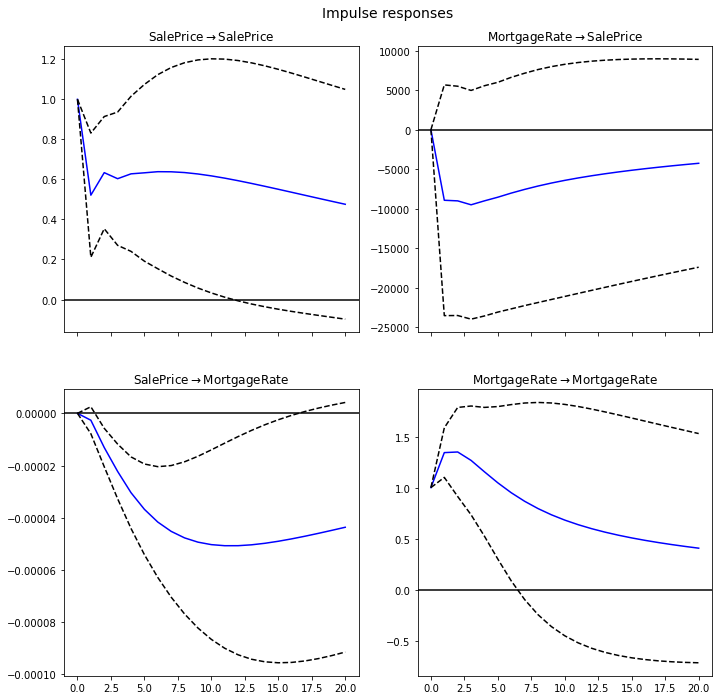

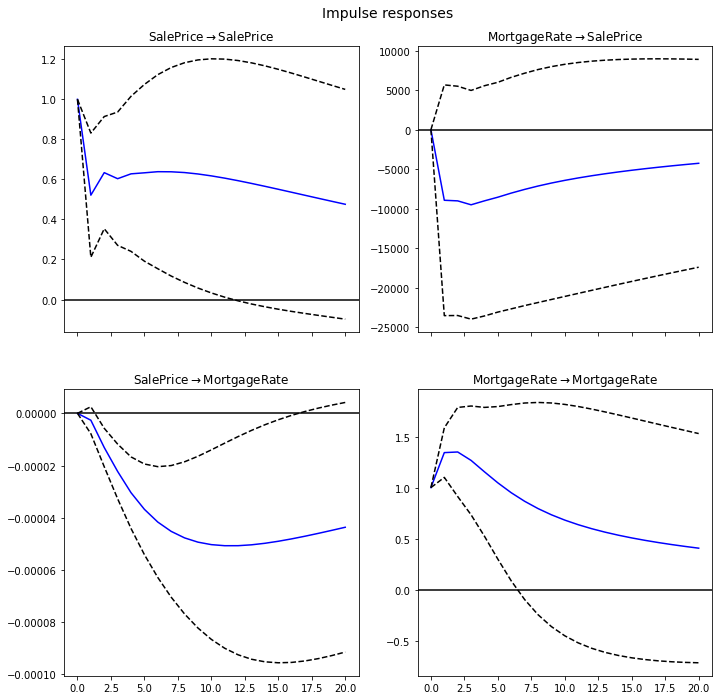

In [10]:
irf = result.irf(20)
irf.plot()

In [11]:
lag_order = result.k_ar
pseudo_for=result.forecast(train.values[-lag_order:],steps=5) 
pseudo_for=pd.DataFrame(pseudo_for)
pseudo_for.rename(columns={0:"SalePrice",1:"MortgageRate",}, inplace=True)
print(pseudo_for)

       SalePrice  MortgageRate
0  328985.896588      2.338587
1  330131.391408      2.266565
2  331126.861007      2.181947
3  332238.773054      2.090750
4  333323.088410      1.997661


In [12]:
#Causality Test

print(result.test_causality('SalePrice', ['MortgageRate'], kind='f')) #f: F test

# H0: m2 and interest rate are not Granger casual to RGDP
#2.253>1.572 H0 rejected: m2 ve interest rate granger casual to RGDP; 
# so to incerase estimation and forecast performence for RGDP you should add these two variable on the right side!!

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: MortgageRate does not Granger-cause SalePrice: fail to reject at 5% significance level. Test statistic: 0.723, critical value: 3.132>, p-value: 0.489>


In [13]:
re=grangercausalitytests(np.column_stack((train['SalePrice'],train['MortgageRate'])),maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8898  , p=0.0975  , df_denom=37, df_num=1
ssr based chi2 test:   chi2=3.1241  , p=0.0771  , df=1
likelihood ratio test: chi2=3.0081  , p=0.0829  , df=1
parameter F test:         F=2.8898  , p=0.0975  , df_denom=37, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7226  , p=0.4928  , df_denom=34, df_num=2
ssr based chi2 test:   chi2=1.6578  , p=0.4365  , df=2
likelihood ratio test: chi2=1.6236  , p=0.4441  , df=2
parameter F test:         F=0.7226  , p=0.4928  , df_denom=34, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5115  , p=0.6773  , df_denom=31, df_num=3
ssr based chi2 test:   chi2=1.8810  , p=0.5975  , df=3
likelihood ratio test: chi2=1.8359  , p=0.6072  , df=3
parameter F test:         F=0.5115  , p=0.6773  , df_denom=31, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8182  , p=0.5245  , df_d

In [14]:
#Johansen Approach

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')


In [15]:
#Two lag difference model


joh_model3 = coint_johansen(series,0,2) # k_ar_diff +1 = K
joh_output(joh_model3)

   max_eig_stat  trace_stat
0     21.952081   23.949989
1      1.997908    1.997908 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [16]:
# Model 2: with linear trend only
joh_model2 = coint_johansen(series,1,2) # k_ar_diff +1 = K
joh_output(joh_model2)

   max_eig_stat  trace_stat
0     22.047497   24.884343
1      2.836845    2.836845 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]] 



In [17]:
# Model 1: no constant/trend (deterministc) term

joh_model1 = coint_johansen(series,-1,2) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0      6.471246    6.933707
1      0.462461    0.462461 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [24]:
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test = 'ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
grangers_causation_matrix(train, variables = train.columns)
model = VECM(series)
results = model.fit()
results.summary()


C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


,coef,std err,z,P>|z|,[0.025,0.975]
L1.SalePrice,-0.4302,0.142,-3.036,0.002,-0.708,-0.152
L1.MortgageRate,-5054.8659,5862.193,-0.862,0.389,-1.65e+04,6434.822
,coef,std err,z,P>|z|,[0.025,0.975]
L1.SalePrice,1.338e-06,2.9e-06,0.462,0.644,-4.34e-06,7.01e-06
L1.MortgageRate,0.6263,0.120,5.230,0.000,0.392,0.861
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0035,0.002,1.643,0.100,-0.001,0.008
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-9.446e-08,4.32e-08,-2.188,0.029,-1.79e-07,-9.86e-09
,coef,std err,z,P>|z|,[0.025,0.975]


In [25]:
model = VECM(series)
results = model.fit()
results.summary()


C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


,coef,std err,z,P>|z|,[0.025,0.975]
L1.SalePrice,-0.4302,0.142,-3.036,0.002,-0.708,-0.152
L1.MortgageRate,-5054.8659,5862.193,-0.862,0.389,-1.65e+04,6434.822
,coef,std err,z,P>|z|,[0.025,0.975]
L1.SalePrice,1.338e-06,2.9e-06,0.462,0.644,-4.34e-06,7.01e-06
L1.MortgageRate,0.6263,0.120,5.230,0.000,0.392,0.861
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0035,0.002,1.643,0.100,-0.001,0.008
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-9.446e-08,4.32e-08,-2.188,0.029,-1.79e-07,-9.86e-09
,coef,std err,z,P>|z|,[0.025,0.975]


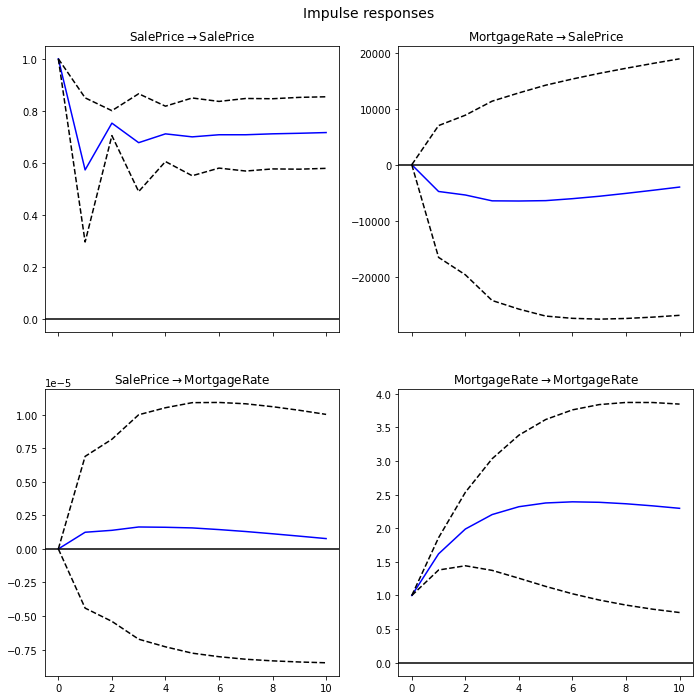

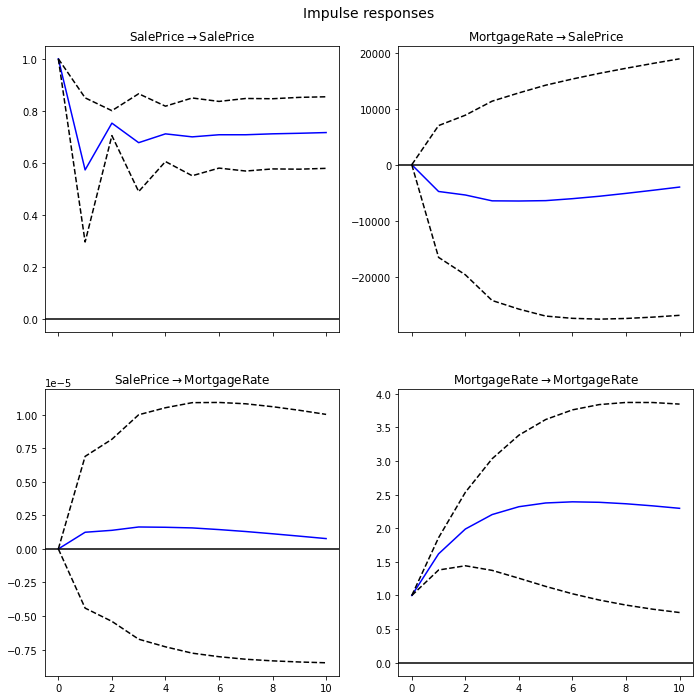

In [26]:
impulse=results.irf(10)
impulse.plot()

In [27]:
pd.DataFrame(results.predict(steps=10))

,0,1
0,329853.168707,2.341740
1,331446.061293,2.275731
2,332898.098465,2.187434
3,334503.090984,2.085542
4,336087.318989,1.975984
5,337693.277593,1.862304
6,339283.666435,1.746807
7,340862.300965,1.630904
8,342420.254452,1.515487
9,343956.923556,1.401101


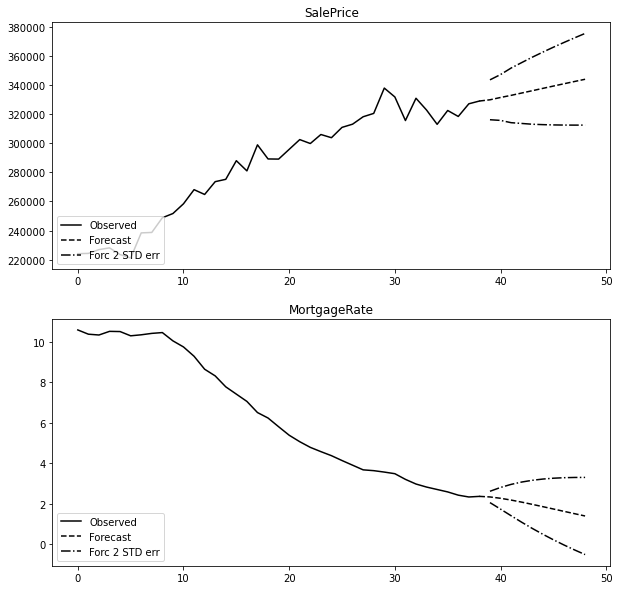

In [28]:
results.plot_forecast(10)

In [29]:
#All things and analysis considired, VECM model gives more accurate and statistically significant results than VAR model.